In [508]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [509]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_color_codes()

In [510]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [511]:
### CONFIGURE RUNS
run_train = False # Disables training & processing of train set; Set it to True for the first time to create a model
#test_location = "Bondville" #Folder name
test_location = "Boulder" #Folder name
#test_location = "Desert_Rock" #Folder name
#test_location = "Fort_Peck" #Folder name
#test_location = "Goodwin_Creek" #Folder name
#test_location = "Penn_State" #Folder name
#test_location = "Sioux_Falls" #Folder name

# All_locations
#bvl = Location(40.1134,-88.3695, 'US/Central', 217.932, 'Bondville')
bvl = Location(40.0150,-105.2705, 'US/Mountain', 1655.064, 'Boulder')
#bvl = Location(36.621,-116.043, 'US/Pacific', 1010.1072, 'Desert Rock')
# bvl = Location(48,-106.449, 'US/Mountain', 630.0216, 'Fort Peck')
# bvl = Location(34.2487,-89.8925, 'US/Central', 98, 'Goodwin Creek')
# bvl = Location(40.798,-77.859, 'US/Eastern', 351.74, 'Penn State')
# bvl = Location(43.544,-96.73, 'US/Central', 448.086, 'Sioux Falls')



test_year = "2015"


# TEST year 2009
times = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',tz=bvl.tz)   # 12 months
#  TEST year 2015
#times = pd.DatetimeIndex(start='2015-01-01', end='2016-01-01', freq='1min',tz=bvl.tz)   # 12 months 
# TEST year 2016
#times = pd.DatetimeIndex(start='2016-01-01', end='2017-01-01', freq='1min',tz=bvl.tz)   # 12 months 
# Test year 2017
#times = pd.DatetimeIndex(start='2017-01-01', end='2018-01-01', freq='1min',tz=bvl.tz)   # 12 months 


In [512]:
 if run_train:
    # TRAIN set
    times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                            tz=bvl.tz)   # 24 months of 2010 and 2011 - For training
    cs_2010and2011 = bvl.get_clearsky(times2010and2011) # ineichen with climatology table by default
    cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
    cs_2010and2011.reset_index(inplace=True)

    cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
    cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
    cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
    cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
    cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
    cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)


    cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
    print(cs_2010and2011.shape)
    cs_2010and2011.head()

(1051200, 7)


In [513]:
# TEST set


cs_test = bvl.get_clearsky(times)
cs_test.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_test.reset_index(inplace=True)

cs_test['index']=cs_test['index'].apply(lambda x:x.to_datetime())
cs_test['year'] = cs_test['index'].apply(lambda x:x.year)
cs_test['month'] = cs_test['index'].apply(lambda x:x.month)
cs_test['day'] = cs_test['index'].apply(lambda x:x.day)
cs_test['hour'] = cs_test['index'].apply(lambda x:x.hour)
cs_test['min'] = cs_test['index'].apply(lambda x:x.minute)

cs_test.drop(cs_test.index[-1], inplace=True)
print(cs_test.shape)

(525600, 7)


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [514]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [515]:
 if run_train:
    # Train Set
    path = r'./data/' + test_location + '/Exp_1_train'
    print("train_path:",path)
    all_files = glob.glob(path + "/*.dat")
    all_files.sort()

    df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                     index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
    print(df_big_train.shape)
    df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
    print(df_train.shape)

train_path: ./data/Boulder/Exp_1_train
(1050018, 48)
(1050018, 50)


In [516]:
# Test set
path = r'./data/' + test_location + '/Exp_1_test/' + test_year
print(path)
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
print(df_big_test[df_big_test['dw_solar']==-9999.9].shape)
df_test = pd.merge(df_big_test, cs_test, on=['year','month','day','hour','min'])
print(df_big_test.shape)

./data/Boulder/Exp_1_test/2009
(3702, 48)
(525132, 48)


### Merging Clear Sky GHI And the big dataframe

In [517]:
if run_train:
    # TRAIN set
    #updating the same dataframe by dropping the index columns from clear sky model
    df_train.drop(['index'],axis=1, inplace=True)
    # Resetting Index
    df_train.reset_index(drop=True, inplace=True)

In [518]:
# TEST set
#updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'],axis=1, inplace=True)
# Resetting Index
df_test.reset_index(drop=True, inplace=True)

### Managing missing values

In [519]:
if run_train:
    # TRAIN set
    #Dropping rows with two or more -9999.9 values in columns
    missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0] #Get indices of all rows with 2 or more -9999.9
    df_train.drop(missing_data_indices, axis=0, inplace=True) # Drop those inddices
    print(df_train.shape)
    df_train.reset_index(drop=True, inplace=True) # 2nd time - Resetting index

(1034397, 49)


In [520]:
# TEST set
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
print(df_test.shape)
df_test.reset_index(drop=True, inplace=True) # 2nd time - Reseting Index

(505639, 49)


#### First resetting index after dropping rows in the previous part of the code

In [521]:
if run_train:
    # TRAIN set
    one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]
    print(len(one_miss_train_idx))
    df_train.shape

    col_names = df_train.columns
    from collections import defaultdict
    stats = defaultdict(int)
    total_single_missing_values = 0
    for name in col_names:
        col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
        missing_indices = np.where((df_train[name] == -9999.9))
        stats[name] = len(missing_indices[0])
        df_train[name].loc[missing_indices] = col_mean
        total_single_missing_values += sum(df_train[name] == -9999.9)

    train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]
    print(len(train))

10058


/home/praveen/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0


In [522]:
# TEST set
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)
col_names_test = df_test.columns

from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
print(len(test))
df_test.shape

/home/praveen/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0


(505639, 49)

### Exploratory Data analysis

In [523]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

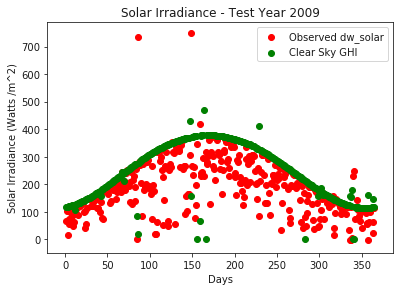

In [524]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'Figure 2.jpg', bbox_inches = 'tight')

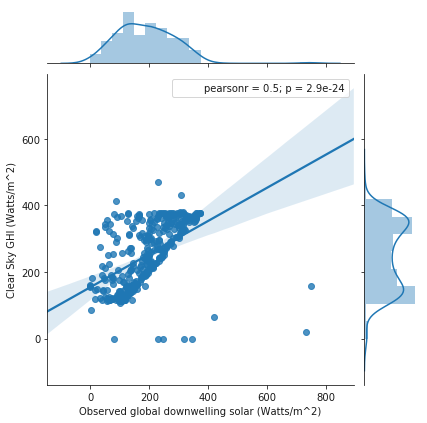

In [525]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'Figure 3', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [526]:
if run_train:
    # TRAIN dataset
    df_train = df_train[df_train['ghi']!=0]
    df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
    df_train.reset_index(inplace=True)

    print("train Kt max: "+str(df_train['Kt'].max()))
    print("train Kt min: "+str(df_train['Kt'].min()))
    print("train Kt mean: "+str(df_train['Kt'].mean()))

train Kt max: 275783.511009
train Kt min: -1561.16866474
train Kt mean: 3.97720123135


In [527]:
# TEST dataset
df_test = df_test[df_test['ghi']!=0]
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']
df_test.reset_index(inplace=True)

print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))

test Kt max: 18622.0035826
test Kt min: -1997.84146167
test Kt mean: 3.20825588533


In [528]:
if run_train:
    # TRAIN dataset
    df_train= df_train[df_train['Kt']< 5000]
    df_train= df_train[df_train['Kt']> -1000]

In [529]:
# Test dataset
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

### Making 4 Kt columns

In [530]:
if run_train:
    # Train dataset
    df_train['Kt_2'] = df_train['Kt']
    df_train['Kt_3'] = df_train['Kt']
    df_train['Kt_4'] = df_train['Kt']

In [531]:
# Test dataset
df_test['Kt_2'] = df_test['Kt']
df_test['Kt_3'] = df_test['Kt']
df_test['Kt_4'] = df_test['Kt']

#### Group the data (train dataframe)

In [532]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()
Kt_2 = df_train.groupby(['year','month','day','hour'])['Kt_2'].mean()
Kt_3 = df_train.groupby(['year','month','day','hour'])['Kt_3'].mean()
Kt_4 = df_train.groupby(['year','month','day','hour'])['Kt_4'].mean()

In [533]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt,Kt_2,Kt_3,Kt_4], axis=1)

#### Groupdata - test dataframe

In [534]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()
test_Kt_2 = df_test.groupby(['month','day','hour'])['Kt_2'].mean()
test_Kt_3 = df_test.groupby(['month','day','hour'])['Kt_3'].mean()
test_Kt_4 = df_test.groupby(['month','day','hour'])['Kt_4'].mean()

In [535]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt,test_Kt_2,test_Kt_3,test_Kt_4], axis=1)

In [536]:
#df_new_test.loc[2].xs(17,level='day')

### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [537]:
if run_train:
    levels_index= []
    for m in df_new_train.index.levels:
        levels_index.append(m)
    for i in levels_index[0]:
        for j in levels_index[1]:
            df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)
            df_new_train.loc[i].loc[j]['Kt_2'] = df_new_train.loc[i].loc[j]['Kt_2'].shift(-2)
            df_new_train.loc[i].loc[j]['Kt_3'] = df_new_train.loc[i].loc[j]['Kt_3'].shift(-3)
            df_new_train.loc[i].loc[j]['Kt_4'] = df_new_train.loc[i].loc[j]['Kt_4'].shift(-4)
    df_new_train = df_new_train[~(df_new_train['Kt_4'].isnull())]

#### Test dataset

In [538]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [539]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)
        df_new_test.loc[i].loc[j]['Kt_2'] = df_new_test.loc[i].loc[j]['Kt_2'].shift(-2)
        df_new_test.loc[i].loc[j]['Kt_3'] = df_new_test.loc[i].loc[j]['Kt_3'].shift(-3)
        df_new_test.loc[i].loc[j]['Kt_4'] = df_new_test.loc[i].loc[j]['Kt_4'].shift(-4)

In [540]:
df_new_test = df_new_test[~(df_new_test['Kt_4'].isnull())]

### Normalize train and test dataframe

In [541]:
if run_train:
    # TRAIN set
    train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
    train_norm.reset_index(inplace=True,drop=True)

In [542]:
# TEST set
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [543]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [544]:
if run_train:
    # TRAIN set
    train_lim = roundup(train_norm.shape[0])
    train_random = train_norm.sample(train_lim-train_norm.shape[0])
    train_norm = train_norm.append(train_random)

    X1 = train_norm.drop(['Kt','Kt_2','Kt_3','Kt_4'],axis=1)
    y1 = train_norm[['Kt','Kt_2','Kt_3','Kt_4']]

    print("X1_train shape is {}".format(X1.shape))
    print("y1_train shape is {}".format(y1.shape))

    X_train = np.array(X1)
    y_train  = np.array(y1)

X1_train shape is (9400, 22)
y1_train shape is (9400, 4)


In [545]:
# TEST set
test_lim = roundup(test_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])
test_norm = test_norm.append(test_random)

X2 = test_norm.drop(['Kt','Kt_2','Kt_3','Kt_4'],axis=1)
y2 = test_norm[['Kt','Kt_2','Kt_3','Kt_4']]

print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X_test = np.array(X2)
y_test = np.array(y2)

X2_test shape is (3200, 22)
y2_test shape is (3200, 4)


### start of RNN

In [546]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [547]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [548]:
if run_train:
    # Instantiating Model Class
    input_dim = 22
    hidden_dim = 15
    layer_dim = 1
    output_dim = 4
    batch_size = 100

    model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

    # Instantiating Loss Class
    criterion = nn.MSELoss()

    # Instantiate Optimizer Class
    learning_rate = 0.001
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # initializing lists to store losses over epochs:
    train_loss = []
    train_iter = []
else:
    model = torch.load('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'torch_model')

In [549]:
# TEst set


test_loss = []
test_iter = []
# converting numpy array to torch tensor

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# Convert to Float tensor

X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

In [550]:
if run_train:
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    X_train = X_train.type(torch.FloatTensor)
    y_train = y_train.type(torch.FloatTensor)
    # Training the model
    seq_dim = 1

    n_iter =0
    num_samples = len(X_train)
    test_samples = len(X_test)
    batch_size = 100
    num_epochs = 1000
    feat_dim = X_train.shape[1]


    for epoch in range(num_epochs):
        for i in range(0, int(num_samples/batch_size -1)):


            features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
            Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])

            #print("Kt_value={}".format(Kt_value))

            optimizer.zero_grad()

            outputs = model(features)
            #print("outputs ={}".format(outputs))

            loss = criterion(outputs, Kt_value)

            train_loss.append(loss.data[0])
            train_iter.append(n_iter)

            #print("loss = {}".format(loss))
            loss.backward()

            optimizer.step()

            n_iter += 1  
            test_batch_mse =list()    
            if n_iter%100 == 0:
                for i in range(0,int(test_samples/batch_size -1)):
                    features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                    Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])

                    outputs = model(features)

                    test_batch_mse.append(np.mean([(Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2],axis=1))

                test_iter.append(n_iter)
                test_loss.append(np.mean([test_batch_mse],axis=1))

                print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], test_loss[-1]))       
    torch.save(model,'RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'torch_model')

Epoch: 1 Iteration: 100. Train_MSE: 0.03832287713885307. Test_MSE: [[[ 0.12061296  0.03091992  0.00825078  0.04777953]]]
Epoch: 2 Iteration: 200. Train_MSE: 0.03326038271188736. Test_MSE: [[[ 0.10679609  0.03094405  0.00756924  0.04006466]]]
Epoch: 3 Iteration: 300. Train_MSE: 0.028695719316601753. Test_MSE: [[[ 0.09557553  0.03094332  0.00702937  0.03376288]]]
Epoch: 4 Iteration: 400. Train_MSE: 0.02027653157711029. Test_MSE: [[[ 0.08644794  0.03094414  0.00658457  0.0286114 ]]]
Epoch: 5 Iteration: 500. Train_MSE: 0.016247019171714783. Test_MSE: [[[ 0.07900257  0.03093149  0.00622283  0.02439137]]]
Epoch: 6 Iteration: 600. Train_MSE: 0.017917541787028313. Test_MSE: [[[ 0.07290123  0.03089711  0.00593458  0.02090653]]]
Epoch: 7 Iteration: 700. Train_MSE: 0.015244700014591217. Test_MSE: [[[ 0.06784897  0.03084437  0.00570457  0.01798662]]]
Epoch: 8 Iteration: 800. Train_MSE: 0.011180789209902287. Test_MSE: [[[ 0.06374811  0.03078108  0.00552332  0.01559514]]]
Epoch: 9 Iteration: 900. Tr

Epoch: 73 Iteration: 6800. Train_MSE: 0.0031603595707565546. Test_MSE: [[[ 0.04050383  0.02812497  0.00480854  0.00314282]]]
Epoch: 74 Iteration: 6900. Train_MSE: 0.003992974292486906. Test_MSE: [[[ 0.04042875  0.02809488  0.00481104  0.00312998]]]
Epoch: 75 Iteration: 7000. Train_MSE: 0.003116816282272339. Test_MSE: [[[ 0.04035565  0.02806892  0.00481306  0.00311779]]]
Epoch: 76 Iteration: 7100. Train_MSE: 0.0026904239784926176. Test_MSE: [[[ 0.04028275  0.02804365  0.00481452  0.00310606]]]
Epoch: 77 Iteration: 7200. Train_MSE: 0.002111581386998296. Test_MSE: [[[ 0.04021114  0.02801978  0.00481557  0.00309403]]]
Epoch: 78 Iteration: 7300. Train_MSE: 0.0015868732007220387. Test_MSE: [[[ 0.04014512  0.02799392  0.00481703  0.00308073]]]
Epoch: 79 Iteration: 7400. Train_MSE: 0.002181441755965352. Test_MSE: [[[ 0.04007982  0.02796695  0.00481863  0.00306753]]]
Epoch: 80 Iteration: 7500. Train_MSE: 0.0026885769329965115. Test_MSE: [[[ 0.040011    0.02793998  0.00482081  0.00305536]]]
Epoc

Epoch: 144 Iteration: 13400. Train_MSE: 0.0017545068403705955. Test_MSE: [[[ 0.03678977  0.02665886  0.00489299  0.0025699 ]]]
Epoch: 145 Iteration: 13500. Train_MSE: 0.0024629838299006224. Test_MSE: [[[ 0.03674427  0.02664012  0.00489412  0.00256412]]]
Epoch: 146 Iteration: 13600. Train_MSE: 0.0021445166785269976. Test_MSE: [[[ 0.03669892  0.0266211   0.0048954   0.00255907]]]
Epoch: 147 Iteration: 13700. Train_MSE: 0.0019221031107008457. Test_MSE: [[[ 0.03665482  0.02660429  0.00489599  0.0025543 ]]]
Epoch: 148 Iteration: 13800. Train_MSE: 0.013380492106080055. Test_MSE: [[[ 0.03660932  0.0265875   0.00489607  0.00254952]]]
Epoch: 149 Iteration: 13900. Train_MSE: 0.001114505808800459. Test_MSE: [[[ 0.03656794  0.02657066  0.00489682  0.00254409]]]
Epoch: 150 Iteration: 14000. Train_MSE: 0.0012132374104112387. Test_MSE: [[[ 0.03652863  0.02655286  0.00489762  0.00253776]]]
Epoch: 151 Iteration: 14100. Train_MSE: 0.0024497646372765303. Test_MSE: [[[ 0.03648701  0.02653474  0.00489868  

Epoch: 213 Iteration: 19900. Train_MSE: 0.0011071438202634454. Test_MSE: [[[ 0.03441746  0.02566616  0.0049315   0.00230565]]]
Epoch: 215 Iteration: 20000. Train_MSE: 0.0008544047013856471. Test_MSE: [[[ 0.03438988  0.02565312  0.00493196  0.00230194]]]
Epoch: 216 Iteration: 20100. Train_MSE: 0.0012686805566772819. Test_MSE: [[[ 0.03435981  0.02564039  0.00493253  0.00229883]]]
Epoch: 217 Iteration: 20200. Train_MSE: 0.0016516962787136436. Test_MSE: [[[ 0.03432815  0.02562697  0.00493322  0.0022961 ]]]
Epoch: 218 Iteration: 20300. Train_MSE: 0.001257972908206284. Test_MSE: [[[ 0.03429789  0.02561549  0.00493349  0.00229374]]]
Epoch: 219 Iteration: 20400. Train_MSE: 0.001363487564958632. Test_MSE: [[[ 0.03426754  0.02560342  0.00493357  0.00229162]]]
Epoch: 220 Iteration: 20500. Train_MSE: 0.001147267292253673. Test_MSE: [[[ 0.03423715  0.02559139  0.00493366  0.0022892 ]]]
Epoch: 221 Iteration: 20600. Train_MSE: 0.0007135731866583228. Test_MSE: [[[ 0.03421     0.02557878  0.00493408  0

Epoch: 283 Iteration: 26400. Train_MSE: 0.0008987331530079246. Test_MSE: [[[ 0.03272227  0.02495109  0.00494726  0.00216095]]]
Epoch: 284 Iteration: 26500. Train_MSE: 0.0008640997693873942. Test_MSE: [[[ 0.03270046  0.02494244  0.00494736  0.00215934]]]
Epoch: 286 Iteration: 26600. Train_MSE: 0.000690409098751843. Test_MSE: [[[ 0.03268041  0.02493263  0.00494751  0.00215701]]]
Epoch: 287 Iteration: 26700. Train_MSE: 0.002800967078655958. Test_MSE: [[[ 0.03265947  0.02492287  0.00494781  0.00215503]]]
Epoch: 288 Iteration: 26800. Train_MSE: 0.0020338520407676697. Test_MSE: [[[ 0.03263653  0.02491345  0.00494826  0.00215318]]]
Epoch: 289 Iteration: 26900. Train_MSE: 0.0009017026168294251. Test_MSE: [[[ 0.03261363  0.0249052   0.00494844  0.00215184]]]
Epoch: 290 Iteration: 27000. Train_MSE: 0.009605390951037407. Test_MSE: [[[ 0.03259095  0.02489601  0.00494828  0.00215082]]]
Epoch: 291 Iteration: 27100. Train_MSE: 0.0009066867642104626. Test_MSE: [[[ 0.03256811  0.02488736  0.00494796  0

Epoch: 353 Iteration: 32900. Train_MSE: 0.0007975116604939103. Test_MSE: [[[ 0.03145034  0.02441899  0.00495218  0.00207239]]]
Epoch: 354 Iteration: 33000. Train_MSE: 0.010535540990531445. Test_MSE: [[[ 0.03143211  0.02441042  0.00495195  0.00207182]]]
Epoch: 355 Iteration: 33100. Train_MSE: 0.0007590075838379562. Test_MSE: [[[ 0.03141536  0.02440394  0.00495187  0.0020711 ]]]
Epoch: 356 Iteration: 33200. Train_MSE: 0.00045473803766071796. Test_MSE: [[[ 0.03139975  0.02439656  0.00495192  0.0020697 ]]]
Epoch: 358 Iteration: 33300. Train_MSE: 0.0008586785988882184. Test_MSE: [[[ 0.03138474  0.02438921  0.00495206  0.00206812]]]
Epoch: 359 Iteration: 33400. Train_MSE: 0.0007633189670741558. Test_MSE: [[[ 0.0313678   0.0243825   0.00495226  0.00206689]]]
Epoch: 360 Iteration: 33500. Train_MSE: 0.00074963946826756. Test_MSE: [[[ 0.03134969  0.02437579  0.00495235  0.00206592]]]
Epoch: 361 Iteration: 33600. Train_MSE: 0.0007548191351816058. Test_MSE: [[[ 0.03133286  0.02437002  0.00495213  

Epoch: 423 Iteration: 39400. Train_MSE: 0.0007836707518436015. Test_MSE: [[[ 0.03046568  0.02400377  0.00495044  0.00201491]]]
Epoch: 424 Iteration: 39500. Train_MSE: 0.0008063673158176243. Test_MSE: [[[ 0.03045132  0.02399808  0.00495038  0.00201432]]]
Epoch: 425 Iteration: 39600. Train_MSE: 0.0007639199029654264. Test_MSE: [[[ 0.03043764  0.02399351  0.00495005  0.00201392]]]
Epoch: 426 Iteration: 39700. Train_MSE: 0.0026077525690197945. Test_MSE: [[[ 0.03042339  0.02398574  0.00494985  0.00201369]]]
Epoch: 427 Iteration: 39800. Train_MSE: 0.0004951210576109588. Test_MSE: [[[ 0.0304107   0.02398083  0.00494977  0.00201293]]]
Epoch: 429 Iteration: 39900. Train_MSE: 0.00047938100760802627. Test_MSE: [[[ 0.03039923  0.02397477  0.00494979  0.00201172]]]
Epoch: 430 Iteration: 40000. Train_MSE: 0.0007801228202879429. Test_MSE: [[[ 0.03038703  0.02396923  0.00494988  0.00201079]]]
Epoch: 431 Iteration: 40100. Train_MSE: 0.0019208837766200304. Test_MSE: [[[ 0.03037297  0.02396374  0.0049500

Epoch: 493 Iteration: 45900. Train_MSE: 0.0006493161781691015. Test_MSE: [[[ 0.02968646  0.02366788  0.00494493  0.00197581]]]
Epoch: 494 Iteration: 46000. Train_MSE: 0.0006205200916156173. Test_MSE: [[[ 0.02967536  0.02366326  0.00494501  0.00197499]]]
Epoch: 495 Iteration: 46100. Train_MSE: 0.0008477919618599117. Test_MSE: [[[ 0.02966376  0.02365824  0.00494498  0.00197444]]]
Epoch: 496 Iteration: 46200. Train_MSE: 0.0005887907464057207. Test_MSE: [[[ 0.02965269  0.02365484  0.00494476  0.00197409]]]
Epoch: 497 Iteration: 46300. Train_MSE: 0.0004331858071964234. Test_MSE: [[[ 0.02964137  0.02364872  0.00494443  0.00197401]]]
Epoch: 498 Iteration: 46400. Train_MSE: 0.00043392053339630365. Test_MSE: [[[ 0.02963106  0.02364444  0.00494429  0.00197375]]]
Epoch: 499 Iteration: 46500. Train_MSE: 0.0005021581309847534. Test_MSE: [[[ 0.02962174  0.02363931  0.00494424  0.00197293]]]
Epoch: 501 Iteration: 46600. Train_MSE: 0.0004287062620278448. Test_MSE: [[[ 0.02961277  0.02363462  0.0049443

Epoch: 563 Iteration: 52400. Train_MSE: 0.004558699205517769. Test_MSE: [[[ 0.02905643  0.02338877  0.0049363   0.00194813]]]
Epoch: 564 Iteration: 52500. Train_MSE: 0.00035614697844721377. Test_MSE: [[[ 0.02904905  0.02338461  0.00493634  0.00194731]]]
Epoch: 565 Iteration: 52600. Train_MSE: 0.0011190936202183366. Test_MSE: [[[ 0.02904084  0.02338037  0.00493636  0.00194663]]]
Epoch: 566 Iteration: 52700. Train_MSE: 0.0006121931364759803. Test_MSE: [[[ 0.02903136  0.02337704  0.00493641  0.001946  ]]]
Epoch: 567 Iteration: 52800. Train_MSE: 0.0006000973517075181. Test_MSE: [[[ 0.02902206  0.02337348  0.00493615  0.00194581]]]
Epoch: 568 Iteration: 52900. Train_MSE: 0.0005129828932695091. Test_MSE: [[[ 0.02901362  0.02336988  0.00493584  0.00194572]]]
Epoch: 569 Iteration: 53000. Train_MSE: 0.00043335024383850396. Test_MSE: [[[ 0.02900431  0.02336429  0.00493557  0.00194576]]]
Epoch: 570 Iteration: 53100. Train_MSE: 0.0004046921676490456. Test_MSE: [[[ 0.0289963   0.02336056  0.0049354

Epoch: 633 Iteration: 58900. Train_MSE: 0.0015484747709706426. Test_MSE: [[[ 0.02854716  0.02315224  0.00492638  0.0019268 ]]]
Epoch: 634 Iteration: 59000. Train_MSE: 0.0003801136335823685. Test_MSE: [[[ 0.02853958  0.02314823  0.00492607  0.00192685]]]
Epoch: 635 Iteration: 59100. Train_MSE: 0.0002892497868742794. Test_MSE: [[[ 0.02853302  0.02314462  0.00492602  0.00192645]]]
Epoch: 636 Iteration: 59200. Train_MSE: 0.00038616490201093256. Test_MSE: [[[ 0.02852694  0.02314086  0.00492599  0.00192583]]]
Epoch: 637 Iteration: 59300. Train_MSE: 0.000475793523946777. Test_MSE: [[[ 0.02851959  0.0231379   0.00492605  0.00192529]]]
Epoch: 638 Iteration: 59400. Train_MSE: 0.0007949713035486639. Test_MSE: [[[ 0.02851188  0.02313436  0.00492599  0.00192502]]]
Epoch: 639 Iteration: 59500. Train_MSE: 0.00037448006332851946. Test_MSE: [[[ 0.02850477  0.02313226  0.00492565  0.00192487]]]
Epoch: 640 Iteration: 59600. Train_MSE: 0.0003874019021168351. Test_MSE: [[[ 0.02849719  0.02312691  0.0049252

Epoch: 703 Iteration: 65400. Train_MSE: 0.0006490882369689643. Test_MSE: [[[ 0.02813756  0.0229471   0.00491738  0.00191038]]]
Epoch: 704 Iteration: 65500. Train_MSE: 0.0006832011276856065. Test_MSE: [[[ 0.02813225  0.02294536  0.00491701  0.00191037]]]
Epoch: 705 Iteration: 65600. Train_MSE: 0.0006722280522808433. Test_MSE: [[[ 0.02812604  0.02294178  0.00491666  0.00191051]]]
Epoch: 706 Iteration: 65700. Train_MSE: 0.0004420591867528856. Test_MSE: [[[ 0.02812003  0.02293789  0.00491649  0.00191051]]]
Epoch: 707 Iteration: 65800. Train_MSE: 0.0020185380708426237. Test_MSE: [[[ 0.02811523  0.02293467  0.00491651  0.00190997]]]
Epoch: 708 Iteration: 65900. Train_MSE: 0.0005052153719589114. Test_MSE: [[[ 0.02810989  0.02293175  0.00491654  0.00190946]]]
Epoch: 709 Iteration: 66000. Train_MSE: 0.00587704312056303. Test_MSE: [[[ 0.02810329  0.02292912  0.00491645  0.00190906]]]
Epoch: 710 Iteration: 66100. Train_MSE: 0.00043747841846197844. Test_MSE: [[[ 0.02809755  0.02292724  0.00491628 

Epoch: 773 Iteration: 71900. Train_MSE: 0.0006252856692299247. Test_MSE: [[[ 0.02780527  0.02276809  0.00490804  0.00189806]]]
Epoch: 774 Iteration: 72000. Train_MSE: 0.0009536989964544773. Test_MSE: [[[ 0.02780002  0.02276644  0.00490798  0.00189778]]]
Epoch: 775 Iteration: 72100. Train_MSE: 0.0004460549680516124. Test_MSE: [[[ 0.02779586  0.02276565  0.00490773  0.00189772]]]
Epoch: 776 Iteration: 72200. Train_MSE: 0.00040548574179410934. Test_MSE: [[[ 0.02779105  0.02276236  0.00490739  0.0018979 ]]]
Epoch: 777 Iteration: 72300. Train_MSE: 0.0004039659397676587. Test_MSE: [[[ 0.02778585  0.02275907  0.00490716  0.00189801]]]
Epoch: 778 Iteration: 72400. Train_MSE: 0.0002821170201059431. Test_MSE: [[[ 0.02778164  0.02275621  0.00490713  0.00189767]]]
Epoch: 779 Iteration: 72500. Train_MSE: 0.0003812609938904643. Test_MSE: [[[ 0.02777755  0.02275332  0.00490712  0.00189721]]]
Epoch: 780 Iteration: 72600. Train_MSE: 0.0004899710766039789. Test_MSE: [[[ 0.02777252  0.02275122  0.0049071

Epoch: 843 Iteration: 78400. Train_MSE: 0.0002734962326940149. Test_MSE: [[[ 0.02752947  0.02261198  0.00489867  0.00188828]]]
Epoch: 844 Iteration: 78500. Train_MSE: 0.0005229117232374847. Test_MSE: [[[ 0.02752657  0.02260991  0.0048987   0.00188793]]]
Epoch: 845 Iteration: 78600. Train_MSE: 0.0007206941372714937. Test_MSE: [[[ 0.02752226  0.0226086   0.00489862  0.00188758]]]
Epoch: 846 Iteration: 78700. Train_MSE: 0.0005349633283913136. Test_MSE: [[[ 0.02751832  0.02260764  0.00489842  0.00188753]]]
Epoch: 847 Iteration: 78800. Train_MSE: 0.0008162753074429929. Test_MSE: [[[ 0.02751493  0.02260579  0.0048981   0.00188763]]]
Epoch: 848 Iteration: 78900. Train_MSE: 0.011790120974183083. Test_MSE: [[[ 0.02751004  0.02260227  0.00489771  0.00188786]]]
Epoch: 849 Iteration: 79000. Train_MSE: 0.0002615003613755107. Test_MSE: [[[ 0.02750633  0.02259972  0.00489764  0.00188777]]]
Epoch: 850 Iteration: 79100. Train_MSE: 0.0003157858154736459. Test_MSE: [[[ 0.02750317  0.02259723  0.00489763 

Epoch: 913 Iteration: 85000. Train_MSE: 0.00037530812551267445. Test_MSE: [[[ 0.02729599  0.02247133  0.0048886   0.00188039]]]
Epoch: 915 Iteration: 85100. Train_MSE: 0.00028578852652572095. Test_MSE: [[[ 0.02729381  0.0224692   0.00488856  0.00188   ]]]
Epoch: 916 Iteration: 85200. Train_MSE: 0.0003689959994517267. Test_MSE: [[[ 0.02729063  0.02246774  0.00488848  0.00187975]]]
Epoch: 917 Iteration: 85300. Train_MSE: 0.0007084750104695559. Test_MSE: [[[ 0.027287    0.02246687  0.00488832  0.00187958]]]
Epoch: 918 Iteration: 85400. Train_MSE: 0.0004642304847948253. Test_MSE: [[[ 0.02728435  0.02246629  0.00488803  0.00187959]]]
Epoch: 919 Iteration: 85500. Train_MSE: 0.0003591539280023426. Test_MSE: [[[ 0.02728111  0.0224636   0.00488771  0.00187982]]]
Epoch: 920 Iteration: 85600. Train_MSE: 0.0005124440649524331. Test_MSE: [[[ 0.02727721  0.0224606   0.00488752  0.00187995]]]
Epoch: 921 Iteration: 85700. Train_MSE: 0.00024287510314024985. Test_MSE: [[[ 0.02727446  0.02245824  0.00488

Epoch: 983 Iteration: 91500. Train_MSE: 0.000330286449752748. Test_MSE: [[[ 0.02710618  0.02234835  0.00487901  0.00187404]]]
Epoch: 984 Iteration: 91600. Train_MSE: 0.0003279226366430521. Test_MSE: [[[ 0.02710366  0.02234654  0.0048789   0.00187403]]]
Epoch: 986 Iteration: 91700. Train_MSE: 0.00028435405693016946. Test_MSE: [[[ 0.02710187  0.02234434  0.00487884  0.0018737 ]]]
Epoch: 987 Iteration: 91800. Train_MSE: 0.002074234886094928. Test_MSE: [[[ 0.02709984  0.0223426   0.00487881  0.0018735 ]]]
Epoch: 988 Iteration: 91900. Train_MSE: 0.0011727442033588886. Test_MSE: [[[ 0.02709693  0.02234181  0.00487878  0.0018732 ]]]
Epoch: 989 Iteration: 92000. Train_MSE: 0.0003280674573034048. Test_MSE: [[[ 0.02709447  0.02234171  0.00487853  0.00187317]]]
Epoch: 990 Iteration: 92100. Train_MSE: 0.008978566154837608. Test_MSE: [[[ 0.02709192  0.02233967  0.00487818  0.00187337]]]
Epoch: 991 Iteration: 92200. Train_MSE: 0.00025990515132434666. Test_MSE: [[[ 0.02708877  0.02233698  0.00487793 

/home/praveen/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [551]:
# JUST TEST CELL

batch_size = 100
seq_dim = 1
test_samples = len(X_test)
batch_size = 100
feat_dim = X_test.shape[1]

# initializing lists to store losses over epochs:
test_loss = []
test_iter = []



for i in range(0,int(test_samples/batch_size -1)):
    features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
    Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
    outputs = model(features)
                
    test_batch_mse.append(np.mean([(Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2],axis=1))
                
    test_iter.append(n_iter)
    test_loss.append(np.mean([test_batch_mse],axis=1))

93000


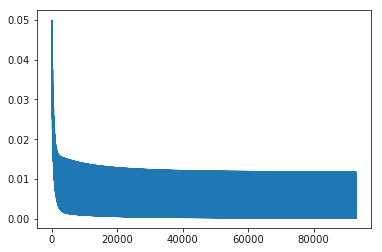

In [552]:
if run_train:
    print(len(train_loss))
    plt.plot(train_loss,'-')

31


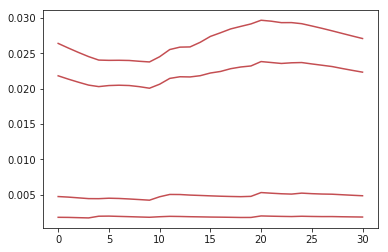

In [553]:
print(len(test_loss))
figLoss = plt.figure()
plt.plot(np.array(test_loss).squeeze(),'r')

figLoss.savefig('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'test_loss.jpg', bbox_inches = 'tight')

#### Demornamization

In [554]:
mse_1 = np.array(test_loss).squeeze()[-1][0]
mse_2 = np.array(test_loss).squeeze()[-1][1]
mse_3 = np.array(test_loss).squeeze()[-1][2]
mse_4 = np.array(test_loss).squeeze()[-1][3]

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)
rmse_3 = np.sqrt(mse_3)
rmse_4 = np.sqrt(mse_4)

print(rmse_1)
print(rmse_2)
print(rmse_3)
print(rmse_4)

0.164525
0.149404
0.069836
0.0432742


In [555]:
rmse_denorm1 = (rmse_1 * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()
rmse_denorm2 = (rmse_2 * (df_new_test['Kt_2'].max() - df_new_test['Kt_2'].min()))+ df_new_test['Kt_2'].mean()
rmse_denorm3 = (rmse_3 * (df_new_test['Kt_3'].max() - df_new_test['Kt_3'].min()))+ df_new_test['Kt_3'].mean()
rmse_denorm4 = (rmse_4 * (df_new_test['Kt_4'].max() - df_new_test['Kt_4'].min()))+ df_new_test['Kt_4'].mean()

print(rmse_denorm1)
print(rmse_denorm2)
print(rmse_denorm3)
print(rmse_denorm4)

0.572121648329
1.04362327401
4.46312278844
54.6116210989


In [556]:
rmse_mean = np.mean([rmse_denorm1, rmse_denorm2, rmse_denorm3, rmse_denorm4])
print(rmse_mean)

15.1726222024


In [557]:
print(df_new_test['Kt'].describe())
print('\n')
print(df_new_test['Kt_2'].describe())
print('\n')
print(df_new_test['Kt_3'].describe())
print('\n')
print(df_new_test['Kt_4'].describe())

count    3163.000000
mean        0.169756
std         0.393624
min        -0.267460
25%        -0.009081
50%        -0.004916
75%         0.125252
max         2.178158
Name: Kt, dtype: float64


count    3163.000000
mean        0.342026
std         0.703577
min        -0.031211
25%        -0.006896
50%        -0.002210
75%         0.367659
max         4.664769
Name: Kt_2, dtype: float64


count    3163.000000
mean        1.086772
std         3.345456
min        -0.017466
25%        -0.005377
50%         0.066067
75%         0.771512
max        48.329415
Name: Kt_3, dtype: float64


count    3163.000000
mean       10.176067
std        45.253311
min        -0.014020
25%        -0.003442
50%         0.266864
75%         1.723366
max      1026.823214
Name: Kt_4, dtype: float64


In [558]:
# Write to file
#f=open('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + 'results.txt', "a+")
#f.write(...)

### Saving train and test losses to a csv

In [559]:
if run_train:
    df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss}, columns=['Train Loss'])
    df_trainLoss.head()

In [560]:
testloss_unsqueezed = np.array(test_loss).squeeze()

In [561]:
df_testLoss = pd.DataFrame(data=testloss_unsqueezed,columns=['mse1','mse2', 'mse3', 'mse4'])
df_testLoss.head()

,mse1,mse2,mse3,mse4
0,0.026378,0.021807,0.004765,0.001834
1,0.025729,0.021338,0.004686,0.001822
2,0.025105,0.020901,0.004580,0.001783
3,0.024517,0.020494,0.004473,0.001749
4,0.024026,0.020282,0.004464,0.001989


In [562]:
df_testLoss.to_csv('RNN Paper Results/Exp2_1/' + test_location + '/' +  test_year + '_TestLoss.csv')
if run_train:
    df_trainLoss.to_csv('RNN Paper Results/Exp2_1/' + test_location + '/'+  test_year + '_TrainLoss.csv')
